<a href="https://colab.research.google.com/github/John-Ragland/ee511_assignments/blob/main/project/final_project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
* [Setup & Data Retrieval](#set-up)
* [Baseline Models](#baseline)
  + [Vegas Baseline](#vegas) : Spread RMSE=16.54, Winner acc=75.7%
  + [Simple Linear Baseline](#simple-linear) : Spread RMSE=20.5, Winner acc=72.1%
* [More Complex Models](#complex-models)
  + [Complex Linear Model](#linear-complex) : Spread RMSE=16.66, Winner acc=%75.2
  + [L1 Regularization](#l1) : Spread RMSE=23.22, Winner acc=65%
  + [Random Forest Model](#random-forest) : Winner acc=76%
* [Neural Networks](#nn)
  + [Linear NN for Predicting the Spread](#linear-spread-nn) : Spread RMSE=12.45
  + [Linear NN for Predicting the Winner](#linear-winner-nn) : Winner acc=83%
* [Compare to Vegas](#compare-vegas)
* [Summary](#summary)



# Setup the Notebook and Get Data<a name="set-up"></a>

In [1]:
# Suppress Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold

In [2]:
# look_back = 3 # games
def get_data(data_type, start_year, end_year=2020, week=None):
    website = 'https://api.collegefootballdata.com/' + data_type
    frames = []
    for year in range(start_year, end_year+1):
        url = website + '?year=%d' % year
        if week:
          # start = max(week - look_back, 1)
          # url += '&startWeek=%d' % start
          url += '&endWeek=%d' % week
        frames.append(pd.read_json(url))
    return pd.concat(frames)

In [3]:
def get_weekly_stats(start_year):
  frames = []
  for week in range(1, 16):
    week_frame = get_data('stats/season', start_year, week=week)
    week_frame['week'] = week+1
    frames.append(week_frame)
  return pd.concat(frames)

In [4]:
# collect the data
begin = 2013
original_stats = get_weekly_stats(begin)
original_games = get_data('games', begin)
original_teams = pd.read_json('https://api.collegefootballdata.com/teams')
original_spread = get_data('metrics/wp/pregame', begin)
original_rankings = get_data('rankings', begin)

In [5]:
# get the games and calculate spread (result)
games = original_games
games = games.assign(result = (games.home_points-games.away_points))
games = games.loc[:, games.columns.intersection(['id', 'season', 'week', 'home_team', 'away_team', 'result', 'excitement_index'])]

# add pregame predictions
spreads = original_spread.loc[:, original_spread.columns.intersection(['gameId', 'spread', 'homeWinProb'])]
spreads.spread *= -1
games = pd.merge(games, spreads, how='left', left_on=['id'], right_on=['gameId']).drop(['gameId'], axis=1)

# get the list of stats
stats = original_stats
stats = stats.drop(columns=['conference'])
w = stats.loc[(stats.team == 'Washington') & (stats.season == begin)]
stat_cols = w.statName.to_list()
stat_cols = list(set(stat_cols)) # remove duplicates
stat_cols.sort()
stat_cols.remove('games')
print(stat_cols)

# add each stat of both teams
s = stats.loc[(stats.statName == 'games')]
s = s.drop(columns=['statName'])
games = pd.merge(games, s.rename(columns={'statValue': 'home_games'}), how='left', left_on=['season', 'home_team', 'week'], right_on=['season', 'team', 'week']).drop(['team'], axis=1)
games = pd.merge(games, s.rename(columns={'statValue': 'away_games'}), how='left', left_on=['season', 'away_team', 'week'], right_on=['season', 'team', 'week']).drop(['team'], axis=1)

for stat in stat_cols:
  s = stats.loc[(stats.statName == stat)]
  s = s.drop(columns=['statName'])
  games = pd.merge(games, s.rename(columns={'statValue': 'home_'+stat}), how='left', left_on=['season', 'home_team', 'week'], right_on=['season', 'team', 'week']).drop(['team'], axis=1)
  games = pd.merge(games, s.rename(columns={'statValue': 'away_'+stat}), how='left', left_on=['season', 'away_team', 'week'], right_on=['season', 'team', 'week']).drop(['team'], axis=1)
  games = games.fillna(0)
  games[stat] = (games['home_'+stat]/games.home_games) - (games['away_'+stat]/games.away_games)
  games = games.drop(columns=['home_'+stat, 'away_'+stat])

games = games.fillna(0)

['firstDowns', 'fourthDownConversions', 'fourthDowns', 'fumblesLost', 'fumblesRecovered', 'interceptionTDs', 'interceptionYards', 'interceptions', 'kickReturnTDs', 'kickReturnYards', 'kickReturns', 'netPassingYards', 'passAttempts', 'passCompletions', 'passesIntercepted', 'passingTDs', 'penalties', 'penaltyYards', 'possessionTime', 'puntReturnTDs', 'puntReturnYards', 'puntReturns', 'rushingAttempts', 'rushingTDs', 'rushingYards', 'thirdDownConversions', 'thirdDowns', 'totalYards', 'turnovers']


In [6]:
# create the table for total points a team scored for and against before a given week
points_per_game = original_teams.loc[:, original_teams.columns.intersection(['school'])]
points_per_game['year'] = 2020
one_season = points_per_game.copy()
for year in range(2004, 2020):
  temp = one_season.copy()
  temp['year'] = year
  points_per_game = pd.concat([points_per_game, temp], ignore_index=True)

points_per_game[('points_for_week1')] = 0.0
points_per_game[('points_against_week1')] = 0.0
scores = original_games.loc[:, original_games.columns.intersection(['season', 'week', 'home_team', 'away_team', 'home_points', 'away_points'])]
scores['week'] += 1
for week in range(2, 16):
  this_scores = scores.loc[scores.week == week]
  this_scores = this_scores.rename(columns={'home_points': ('points_for_week%d' % week), 'away_points': ('points_against_week%d' % week)})
  points_per_game = pd.merge(points_per_game, this_scores, how='left', left_on=['school', 'year'], right_on=['home_team', 'season']).drop(['home_team', 'away_team', 'season', 'week'], axis=1)
  this_scores = scores.loc[scores.week == week]
  this_scores = this_scores.rename(columns={'away_points': ('points_for_week%d' % week), 'home_points': ('points_against_week%d' % week)})
  points_per_game = pd.merge(points_per_game, this_scores, how='left', left_on=['school', 'year'], right_on=['away_team', 'season']).drop(['home_team', 'away_team', 'season', 'week'], axis=1)
  points_per_game = points_per_game.fillna(0)
  points_per_game[('points_for_week%d' % week)] = points_per_game[('points_for_week%d_x' % week)] + points_per_game[('points_for_week%d_y' % week)]
  points_per_game[('points_against_week%d' % week)] = points_per_game[('points_against_week%d_x' % week)] + points_per_game[('points_against_week%d_y' % week)]
  points_per_game = points_per_game.drop(columns=[('points_for_week%d_x' % week), ('points_for_week%d_y' % week), ('points_against_week%d_x' % week), ('points_against_week%d_y' % week)])

for week in range(2, 16):
  points_per_game[('points_for_week%d' % week)] += points_per_game[('points_for_week%d' % (week-1))]
  points_per_game[('points_against_week%d' % week)] += points_per_game[('points_against_week%d' % (week-1))]

for week in range(1,16):
  points = points_per_game.loc[:, points_per_game.columns.intersection(['year', 'school', ('points_for_week%d' % week), ('points_against_week%d' % week)])]
  points = points.rename(columns={('points_for_week%d' % week): 'home_for', ('points_against_week%d' % week): 'home_against'})
  points['week'] = week
  games = pd.merge(games, points, how='left', left_on=['home_team', 'season', 'week'], right_on=['school', 'year', 'week']).drop(['school', 'year'], axis=1)
  points = points.rename(columns={'home_for': 'away_for', 'home_against': 'away_against'})
  games = pd.merge(games, points, how='left', left_on=['away_team', 'season', 'week'], right_on=['school', 'year', 'week']).drop(['school', 'year'], axis=1)
  if (week > 1):
    games['home_for'] = games['home_for_x'].fillna(0) + games['home_for_y'].fillna(0)
    games['home_against'] = games['home_against_x'].fillna(0) + games['home_against_y'].fillna(0)
    games['away_for'] = games['away_for_x'].fillna(0) + games['away_for_y'].fillna(0)
    games['away_against'] = games['away_against_x'].fillna(0) + games['away_against_y'].fillna(0)
    games = games.drop(columns=['home_for_x', 'home_for_y', 'home_against_x', 'home_against_y', 'away_for_x', 'away_for_y', 'away_against_x', 'away_against_y'])

games['home_for'] /= games['home_games']
games['home_against'] /= games['home_games']
games['away_for'] /= games['away_games']
games['away_against'] /= games['away_games']
games = games.fillna(0)

# points_per_game.loc[points_per_game.school == 'Washington']

In [7]:
# add ap-top 25 rankings for each team, -1 if not ranked
rankings = original_rankings.drop(columns = ['seasonType'])
rankings['rank1_name'] = [d[0].get('poll') for d in rankings.polls]
rankings['rank1_ranks'] = [d[0].get('ranks') for d in rankings.polls]
rankings['rank2_name'] = [d[1].get('poll') for d in rankings.polls]
rankings['rank2_ranks'] = [d[1].get('ranks') for d in rankings.polls]
rankings.loc[rankings['rank1_name'] == 'AP Top 25', 'ap'] = rankings.loc[rankings['rank1_name'] == 'AP Top 25'].rank1_ranks
rankings.loc[rankings['rank2_name'] == 'AP Top 25', 'ap'] = rankings.loc[rankings['rank2_name'] == 'AP Top 25'].rank2_ranks
rankings = rankings.drop(columns=['rank1_name', 'rank2_name', 'rank1_ranks', 'rank2_ranks', 'polls'])
rankings = rankings.reset_index(drop=True)
rankings = rankings.explode('ap').reset_index(drop=True)
rankings['school'] = [d.get('school') for d in rankings.ap]
rankings['rank'] = [d.get('rank') for d in rankings.ap]
rankings = rankings.drop(columns=['ap'])
games = pd.merge(games, rankings.rename(columns={'rank': 'home_rank'}), how='left', left_on=['season', 'week', 'home_team'], right_on=['season', 'week', 'school']).drop(['school'], axis=1)
games = pd.merge(games, rankings.rename(columns={'rank': 'away_rank'}), how='left', left_on=['season', 'week', 'away_team'], right_on=['season', 'week', 'school']).drop(['school'], axis=1)
games = games.fillna(-1)


In [8]:
# Add record up to game
# Create list of teams
teams = pd.concat((games['home_team'], games['away_team'])).unique()

# Create Team ID
team_id = np.arange(0,len(teams))
team2id = dict(zip(teams, team_id))

num_seasons = len(games['season'].unique())
season2id = dict(zip(games['season'].unique(), np.arange(0,num_seasons)))
# Create Wins Lookup Table
win_data = np.zeros((num_seasons, len(teams),17))
#print(win_data.shape) #(season, team, week)

# loop through every game in games df
for k in range(len(games)):
  home_team = games['home_team'][k]
  away_team = games['away_team'][k]
  result = np.sign(games['result'][k])
  week = games['week'][k]
  season = games['season'][k]
  
  home_id = team2id[home_team]
  away_id = team2id[away_team]
  seas_id = season2id[season]
  if result == 1: # Home team won
      win_data[seas_id, home_id, (week+1):] += 1
  else: # Away team won
      win_data[seas_id, away_id, (week+1):] += 1

# populate games df
away_wins = []
home_wins = []
for k in range(len(games)):
    week = games['week'][k]
    home = games['home_team'][k]
    away = games['away_team'][k]
    season = games['season'][k]
    away_wins.append(win_data[season2id[season],team2id[away],week])
    home_wins.append(win_data[season2id[season],team2id[home],week])
    
games['home_wins'] = home_wins/games.home_games
games['away_wins'] = away_wins/games.away_games
games = games.fillna(0)
games.replace(np.inf, 0, inplace=True)
games.replace(-np.inf, 0, inplace=True)
games['win_difference'] = games['home_wins'] - games['away_wins']
games = games.drop(columns=['home_wins', 'away_wins'])

In [9]:
def split_data(val_season=2018, test_season=2019):
  games_copy = games.copy()
  games_copy = games_copy.drop(columns=['id', 'home_team', 'away_team'])
  games_copy = games_copy.fillna(0)
  
  test = games_copy.loc[games_copy.season == test_season]
  test = test.drop(columns=['season'])
  if val_season:
    valid = games_copy.loc[games_copy.season == val_season]
    valid = valid.drop(columns=['season'])
    train = games_copy.loc[(games_copy.season != val_season) & (games_copy.season != test_season)]
    train = train.drop(columns=['season'])
    return train, valid, test
  else:
    train = games_copy.loc[games_copy.season != test_season]
    train = train.drop(columns=['season'])
    return train, test

In [10]:
torch.manual_seed(0)
gpu = torch.cuda.is_available()
if gpu:
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print('Using device', device)

Using device cuda


In [224]:
# Getting Spread Result Vector
spread_winner_vector = (np.sign((games['spread'] - games['result']).to_numpy())+1)/2
spread_winner = np.zeros((spread_winner_vector.shape[0],2))

for k in range(len(spread_winner_vector)):  
  if spread_winner_vector[k] == 0:
    spread_winner[k,0] = 1
  else:
    spread_winner[k,1]=1

# Baseline Models<a name="baseline"></a>

## Vegas Spread Results<a name="vegas"></a>

In [11]:
games_copy = games.copy()
vegas_in = games_copy.spread.to_numpy()
vegas_out = games_copy.result.to_numpy()

print('Vegas spread RMSE = %.2f points' % mean_squared_error(vegas_in, vegas_out, squared=False))

vegas_pred = vegas_in
vegas_pred[vegas_pred>0] = 1 # home win
vegas_pred[vegas_pred<0] = 0 # away win

truth = vegas_out
truth[truth>0] =  1
truth[truth<0] = 0

print('Game winner accuracy = %.3f%%' % ((np.sum(vegas_pred==truth) / len(truth))*100.0))

Vegas spread RMSE = 16.54 points
Game winner accuracy = 75.742%


## Simple linear baseline model<a name="simple-linear"></a>

In [12]:
train, test = split_data(val_season=None) # no need for validation in this model
train_in = train.win_difference
train_out = train.result

train_in = train.win_difference.to_numpy()
train_out = train.result.to_numpy()
test_in = test.win_difference.to_numpy()
test_out = test.result.to_numpy()
baseline_model = LinearRegression().fit(train_in.reshape(-1, 1), train_out)

Spread RMSE = 20.53 points
Game winner accuracy = 72.052%


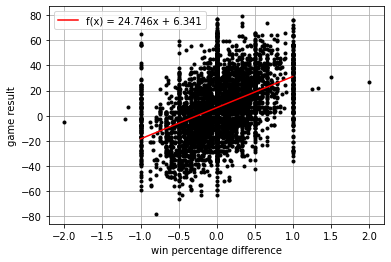

In [13]:
x = np.linspace(-1, 1, 500)
y = baseline_model.coef_ * x + baseline_model.intercept_
y = baseline_model.predict(x.reshape(-1, 1))

plt.xlabel('win percentage difference')
plt.ylabel('game result')
plt.plot(train_in, train_out, '.', color='black')
plt.plot(x, y, '-r', label="f(x) = %.3fx + %.3f" % (baseline_model.coef_, baseline_model.intercept_))
plt.legend()
plt.grid()

prediction = baseline_model.predict(test_in.reshape(-1, 1))
print('Spread RMSE = %.2f points' % mean_squared_error(test_out, prediction, squared=False))

temp_pred = prediction
temp_pred[temp_pred>0] = 1
temp_pred[temp_pred<0] = 0

temp_tru = test_out
temp_tru[temp_tru>0] = 1
temp_tru[temp_tru<0] = 0

print('Game winner accuracy = %.3f%%' % ((np.sum(temp_pred==temp_tru) / len(temp_tru))*100.0))

# More Complex Models<a name="complex-models"></a>

## Linear model with more features<a name="linear-complex"></a>

In [14]:
train, valid, test = split_data()

train_in = train.drop(columns=['result'])
train_out = train.result
valid_in = valid.drop(columns=['result'])
valid_out = valid.result
test_in = test.drop(columns=['result'])
test_out = test.result

In [15]:
model = LinearRegression().fit(train_in, train_out)
prediction = model.predict(test_in)
print('Spread RMSE = %.2f points' % mean_squared_error(test_out, prediction, squared=False))

temp_pred = prediction
temp_pred[temp_pred>0] = 1
temp_pred[temp_pred<0] = 0

temp_tru = test_out
temp_tru[temp_tru>0] = 1
temp_tru[temp_tru<0] = 0

print('Game winner accuracy = %.3f%%' % ((np.sum(temp_pred==temp_tru) / len(temp_tru))*100.0))

Spread RMSE = 15.47 points
Game winner accuracy = 77.712%


## Linear model with L1 Regularization<a name="l1"></a>

In [16]:
alphas = np.linspace(0,600,50)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_valid = []
mse_train = []
num_nonzero = []

for alpha in alphas:
    large_model_lasso = Lasso(alpha=alpha, random_state=77)
    mse_kfold = []
    # Iterate through all folds
    for train_index, test_index in kf.split(train_in):        
        large_model_lasso.fit(train_in.iloc[train_index], train_out.iloc[train_index])
        kf_test_pred = large_model_lasso.predict(train_in.iloc[test_index])
        error = mean_squared_error(train_out.iloc[test_index], kf_test_pred, squared=False)
        mse_kfold.append(error)

    # count number of nonzero coefficients
    num_nonzero.append(np.sum(large_model_lasso.coef_ != 0))
    
    # create error arrays
    mse_train.append(np.mean(mse_kfold))
    large_model_lasso.fit(train_in, train_out)
    pred_valid = large_model_lasso.predict(valid_in)
    mse_valid.append(mean_squared_error(valid_out, pred_valid, squared=False))

Optimum Alpha at 0.00
Optimum Alpha Validation RMSE: 16.66 points


(0.0, 50.0)

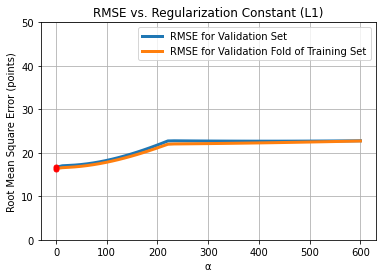

In [17]:
best_alpha = alphas[np.argmin(mse_valid)]
print('Optimum Alpha at %.2f' % best_alpha)
print('Optimum Alpha Validation RMSE: %.2f points' % np.min(mse_valid))

plt.plot(alphas,mse_valid, linewidth=3)
plt.plot(alphas,mse_train, linewidth=3)
plt.plot(best_alpha,np.min(mse_valid),'r.',markersize=10)
plt.plot(alphas[np.argmin(mse_train)],np.min(mse_train),'r.',markersize=10)

plt.legend(['RMSE for Validation Set','RMSE for Validation Fold of Training Set'])
plt.xlabel('α')
plt.ylabel('Root Mean Square Error (points)')
plt.title('RMSE vs. Regularization Constant (L1)')
plt.grid()
plt.ylim([0, 50])

In [18]:
lasso_model = Lasso(alpha=best_alpha, random_state=77)
lasso_model.fit(train_in, train_out)
prediction = lasso_model.predict(test_in)
print('Spread RMSE = %.2f points' % mean_squared_error(test_out, prediction, squared=False))

temp_pred = prediction
temp_pred[temp_pred>0] = 1
temp_pred[temp_pred<0] = 0

temp_tru = test_out
temp_tru[temp_tru>0] = 1
temp_tru[temp_tru<0] = 0

print('Game winner accuracy = %.3f%%' % ((np.sum(temp_pred==temp_tru) / len(temp_tru))*100.0))

Spread RMSE = 18.35 points
Game winner accuracy = 77.476%


## Random Forest<a name="random-forest"></a>

In [19]:
train, valid, test = split_data()

train_in = train.drop(columns=['result'])
train_out = train.result
valid_in = valid.drop(columns=['result'])
valid_out = valid.result
test_in = test.drop(columns=['result'])
test_out = test.result

train_out_winner = train_out
train_out_winner[train_out_winner>0] = 1
train_out_winner[train_out_winner<0] = 0

valid_out_winner = valid_out
valid_out_winner[valid_out_winner>0] = 1
valid_out_winner[valid_out_winner<0] = 0

test_out_winner = test_out
test_out_winner[test_out_winner>0] = 1
test_out_winner[test_out_winner<0] = 0

In [20]:
best_depth = 0
best_acc = 0
for depth in range(1, 30, 2):
  random_model = RandomForestClassifier(max_depth=depth, random_state=0)
  random_model.fit(train_in, train_out_winner)
  acc = (np.sum(random_model.predict(valid_in)==valid_out_winner) / len(valid_out_winner))*100.0
  print('Max Depth: %d \t Accuracy: %.2f' % (depth, acc))
  if acc > best_acc:
    best_acc = acc
    best_depth = depth
  
print('Best Max Depth: %d' % best_depth)

Max Depth: 1 	 Accuracy: 71.38
Max Depth: 3 	 Accuracy: 75.86
Max Depth: 5 	 Accuracy: 76.55
Max Depth: 7 	 Accuracy: 75.52
Max Depth: 9 	 Accuracy: 75.98
Max Depth: 11 	 Accuracy: 75.52
Max Depth: 13 	 Accuracy: 75.75
Max Depth: 15 	 Accuracy: 76.09
Max Depth: 17 	 Accuracy: 76.44
Max Depth: 19 	 Accuracy: 77.47
Max Depth: 21 	 Accuracy: 75.75
Max Depth: 23 	 Accuracy: 76.32
Max Depth: 25 	 Accuracy: 75.63
Max Depth: 27 	 Accuracy: 75.86
Max Depth: 29 	 Accuracy: 75.98
Best Max Depth: 19


Overall game winner accuracy = 78.656%


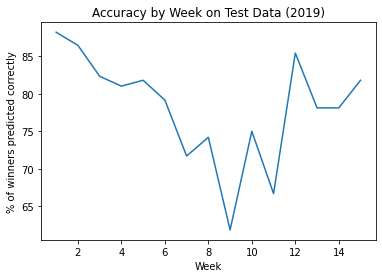

In [21]:
MAX_DEPTH = 9
random_model = RandomForestClassifier(max_depth=MAX_DEPTH, random_state=0)
random_model.fit(train_in, train_out_winner)

acc = []
for week in range(1, 16):
  t = test.loc[(test.week == week)]
  t_in = t.drop(columns=['result'])
  t_out = t.result
  t_out[t_out>0] = 1
  t_out[t_out<0] = 0
  acc.append((np.sum(random_model.predict(t_in)==t_out) / len(t_out))*100.0)

plt.plot(range(1, 16), acc)
plt.xlabel('Week')
plt.ylabel('% of winners predicted correctly')
plt.title('Accuracy by Week on Test Data (2019)')
print('Overall game winner accuracy = %.3f%%' % ((np.sum(random_model.predict(test_in)==test_out_winner) / len(test_out_winner))*100.0))

Our model does better as weeks progress. <br>
The reason accuracy is really high the first few weeks is because the first 3-4 weeks of every college football season is full of out-of-conference games where really good teams play really bad teams and it's often easy to predict the outcome because of that.<br>
As in-conference games start around week 4, our model accuracy goes down. Since those games are with teams of closer strengths.

# Neural Networks<a name="nn"></a>

## John's Neural Net

In [370]:
BATCH_SIZE = 200
EPOCHS = 100
LEARNING_RATE = 0.005

In [374]:
# Add Spread Winner Category
def spread_winner(df):
  df_out = (np.sign((df['spread'] - df['result']).to_numpy())+1)/2
  return df_out

# Setup the data
train, valid, test = split_data()

train_in = train.drop(columns=['result'])
valid_in = valid.drop(columns=['result'])
test_in = test.drop(columns=['result'])

train_out = spread_winner(train)
valid_out = spread_winner(valid)
test_out = spread_winner(test)

train_out_winner = train_out
train_out_winner[train_out_winner>0] = 1
train_out_winner[train_out_winner<0] = 0

valid_out_winner = valid_out
valid_out_winner[valid_out_winner>0] = 1
valid_out_winner[valid_out_winner<0] = 0

test_out_winner = test_out
test_out_winner[test_out_winner>0] = 1
test_out_winner[test_out_winner<0] = 0

data_train_vals = torch.tensor(train_in.to_numpy(), dtype=torch.float, device=device)
data_train_labels = torch.tensor(train_out_winner.to_numpy(), dtype=torch.long, device=device)
data_train = TensorDataset(data_train_vals, data_train_labels)
train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True) 

data_valid_vals = torch.tensor(valid_in.to_numpy(), dtype=torch.float, device=device)
data_valid_labels = torch.tensor(valid_out_winner.to_numpy(), dtype=torch.long, device=device)
data_valid = TensorDataset(data_valid_vals, data_valid_labels)
valid_loader = DataLoader(dataset = data_valid, batch_size = BATCH_SIZE,  shuffle = False)

data_test_vals = torch.tensor(test_in.to_numpy(), dtype=torch.float, device=device)
data_test_labels = torch.tensor(test_out_winner.to_numpy(), dtype=torch.long, device=device)
data_test = TensorDataset(data_test_vals, data_test_labels)
test_loader = DataLoader(dataset = data_test, batch_size = BATCH_SIZE,  shuffle = False)

RuntimeError: ignored

In [372]:
def trainWinner(model, device, train_loader, optimizer, epochs, criterion, verbose=False):
  for epoch in range(epochs):
    model.train()
    batch_loss = 0
    for data, label in train_loader:
      data, label = data.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      batch_loss += loss.item()
    if (verbose) & (epochs%10==0):
      print('Train Epoch: %d  \tLoss: %.6f' % (epoch, np.sqrt(batch_loss/len(train_loader))))

def testWinner(model, device, test_loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  wrong = 0
  with torch.no_grad():
    for data, label in test_loader:
      data, label = data.to(device), label.to(device)
      output = model(data)
      test_loss += criterion(output, label).item()
      correct += torch.sum(torch.argmax(output, dim=1) == label)
      wrong += torch.sum(torch.argmax(output, dim=1) != label)
  print('Test set: Average loss: %.4f' % np.sqrt(test_loss/len(test_loader)))
  print('Accuracy: %.3f%%' % (correct*100/(correct+wrong)))

In [367]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        if gpu:
          self.fc1 = nn.Linear(input_size, 20).cuda()
          self.fc2 = nn.Linear(20, 10).cuda()
          self.fc3 = nn.Linear(10, 2).cuda()
        else:
          self.fc1 = nn.Linear(input_size, 20)
          self.fc2 = nn.Linear(20, 10)
          self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

modelWinner = Net(np.shape(train_in.to_numpy())[1])

RuntimeError: ignored

In [368]:
optimizer = torch.optim.Adam(modelWinner.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [369]:
# Hyperparameters
BATCH_SIZE = 50
EPOCHS = 100
LEARNING_RATE = 0.011

trainWinner(modelWinner, device, train_loader, optimizer, EPOCHS, criterion, verbose=True)

testWinner(modelSpread, device, valid_loader, criterion)

RuntimeError: ignored

## Linear Neural Net for Predicting the Spread<a name="linear-spread-nn"></a>

In [22]:
# Hyperparameters
BATCH_SIZE = 50
EPOCHS = 100
LEARNING_RATE = 0.006

In [334]:
# Setup the data
train, valid, test = split_data()

train_in = train.drop(columns=['result'])
train_out = train.result
valid_in = valid.drop(columns=['result'])
valid_out = valid.result
test_in = test.drop(columns=['result'])
test_out = test.result

data_train_vals = torch.tensor(train_in.to_numpy(), dtype=torch.float, device=device)
data_train_labels = torch.tensor(train_out.to_numpy().reshape(-1, 1), dtype=torch.float, device=device)
data_train = TensorDataset(data_train_vals, data_train_labels)
train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True) 

data_valid_vals = torch.tensor(valid_in.to_numpy(), dtype=torch.float, device=device)
data_valid_labels = torch.tensor(valid_out.to_numpy().reshape(-1, 1), dtype=torch.float, device=device)
data_valid = TensorDataset(data_valid_vals, data_valid_labels)
valid_loader = DataLoader(dataset = data_valid, batch_size = BATCH_SIZE,  shuffle = False)

data_test_vals = torch.tensor(test_in.to_numpy(), dtype=torch.float, device=device)
data_test_labels = torch.tensor(test_out.to_numpy().reshape(-1, 1), dtype=torch.float, device=device)
data_test = TensorDataset(data_test_vals, data_test_labels)
test_loader = DataLoader(dataset = data_test, batch_size = BATCH_SIZE,  shuffle = False)

In [284]:
train_out.to_numpy().reshape(-1,1).shape

(4721, 1)

In [24]:
def train(model, device, train_loader, optimizer, epochs, criterion, verbose=False):
  for epoch in range(epochs):
    model.train()
    batch_loss = 0
    for data, label in train_loader:
      data, label = data.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      batch_loss += loss.item()
    if verbose and epoch % 5 == 0:
      print('Train Epoch: %d  \tLoss: %.6f' % (epoch, np.sqrt(batch_loss/len(train_loader))))

def test(model, device, test_loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, label in test_loader:
      data, label = data.to(device), label.to(device)
      output = model(data)
      test_loss += criterion(output, label).item()
  return np.sqrt(test_loss/len(test_loader))

In [164]:
class Net(nn.Module):
  def __init__(self, input_size):
    super(Net, self).__init__()
    if gpu:
      self.fc1 = nn.Linear(input_size, 20).cuda()
      self.fc2 = nn.Linear(20, 10).cuda()
      self.fc3 = nn.Linear(10, 1).cuda()
    else:
      self.fc1 = nn.Linear(input_size, 20)
      self.fc2 = nn.Linear(20, 10)
      self.fc3 = nn.Linear(10, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

modelSpread = Net(np.shape(train_in.to_numpy())[1])

In [26]:
best_lr = 0
best_loss = 50
epochs = 50
criterion = nn.MSELoss()
for i in range(1, 25):
  lr = 0.001*i
  model = Net(np.shape(train_in.to_numpy())[1])
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  train(model, device, train_loader, optimizer, epochs, criterion)
  loss = test(model, device, valid_loader, criterion)
  print('LR: %.3f \t Loss: %.2f' % (lr, loss))
  if loss < best_loss:
    best_loss = loss
    best_lr = lr

print('Best LR: %.3f with best loss: %.2f' %(best_lr, best_loss))

LR: 0.001 	 Loss: 15.44
LR: 0.002 	 Loss: 15.54
LR: 0.003 	 Loss: 15.08
LR: 0.004 	 Loss: 15.12
LR: 0.005 	 Loss: 15.14
LR: 0.006 	 Loss: 14.84
LR: 0.007 	 Loss: 14.82
LR: 0.008 	 Loss: 15.30
LR: 0.009 	 Loss: 14.85
LR: 0.010 	 Loss: 14.86
LR: 0.011 	 Loss: 14.62
LR: 0.012 	 Loss: 14.96
LR: 0.013 	 Loss: 14.93
LR: 0.014 	 Loss: 14.72
LR: 0.015 	 Loss: 15.28
LR: 0.016 	 Loss: 15.09
LR: 0.017 	 Loss: 15.77
LR: 0.018 	 Loss: 14.87
LR: 0.019 	 Loss: 15.10
LR: 0.020 	 Loss: 14.94
LR: 0.021 	 Loss: 15.17
LR: 0.022 	 Loss: 15.38
LR: 0.023 	 Loss: 14.86
LR: 0.024 	 Loss: 15.14
Best LR: 0.011 with best loss: 14.62


In [27]:
optimizer = torch.optim.Adam(modelSpread.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [28]:
train(modelSpread, device, train_loader, optimizer, EPOCHS, criterion, verbose=True)

Train Epoch: 0  	Loss: 19.902302
Train Epoch: 5  	Loss: 15.581206
Train Epoch: 10  	Loss: 14.942956
Train Epoch: 15  	Loss: 14.672932
Train Epoch: 20  	Loss: 14.203436
Train Epoch: 25  	Loss: 13.954732
Train Epoch: 30  	Loss: 13.880699
Train Epoch: 35  	Loss: 13.714937
Train Epoch: 40  	Loss: 13.611800
Train Epoch: 45  	Loss: 13.441440
Train Epoch: 50  	Loss: 13.356837
Train Epoch: 55  	Loss: 13.258693
Train Epoch: 60  	Loss: 13.082812
Train Epoch: 65  	Loss: 13.132147
Train Epoch: 70  	Loss: 13.007196
Train Epoch: 75  	Loss: 12.942966
Train Epoch: 80  	Loss: 13.227960
Train Epoch: 85  	Loss: 12.869175
Train Epoch: 90  	Loss: 12.888039
Train Epoch: 95  	Loss: 12.612557


In [29]:
loss = test(modelSpread, device, valid_loader, criterion)
print('Validation set: Average loss: %.2f' % loss)

Validation set: Average loss: 15.36


In [30]:
loss = test(modelSpread, device, test_loader, criterion)
print('Test set: Average loss: %.2f' % loss)

Test set: Average loss: 13.61


## Linear Neural Net for Predicting the Winner<a name="linear-winner-nn"></a>

In [346]:
BATCH_SIZE = 200
EPOCHS = 100
LEARNING_RATE = 0.005

In [347]:
train, valid, test = split_data()

train_in = train.drop(columns=['result'])
train_out = train.result
valid_in = valid.drop(columns=['result'])
valid_out = valid.result

train_out_winner = train_out
train_out_winner[train_out_winner>0] = 1
train_out_winner[train_out_winner<0] = 0

valid_out_winner = valid_out
valid_out_winner[valid_out_winner>0] = 1
valid_out_winner[valid_out_winner<0] = 0

test_out_winner = test_out
test_out_winner[test_out_winner>0] = 1
test_out_winner[test_out_winner<0] = 0

data_train_vals = torch.tensor(train_in.to_numpy(), dtype=torch.float, device=device)
data_train_labels = torch.tensor(train_out_winner.to_numpy(), dtype=torch.long, device=device)
data_train = TensorDataset(data_train_vals, data_train_labels)
train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True) 

data_valid_vals = torch.tensor(valid_in.to_numpy(), dtype=torch.float, device=device)
data_valid_labels = torch.tensor(valid_out_winner.to_numpy(), dtype=torch.long, device=device)
data_valid = TensorDataset(data_valid_vals, data_valid_labels)
valid_loader = DataLoader(dataset = data_valid, batch_size = BATCH_SIZE,  shuffle = False)

data_test_vals = torch.tensor(test_in.to_numpy(), dtype=torch.float, device=device)
data_test_labels = torch.tensor(test_out_winner.to_numpy(), dtype=torch.long, device=device)
data_test = TensorDataset(data_test_vals, data_test_labels)
test_loader = DataLoader(dataset = data_test, batch_size = BATCH_SIZE,  shuffle = False)

In [348]:
train_out

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
6434    1.0
6435    0.0
6436    0.0
6437    1.0
6438    0.0
Name: result, Length: 4721, dtype: float64

In [342]:
def trainWinner(model, device, train_loader, optimizer, epochs, criterion, verbose=False):
  for epoch in range(epochs):
    model.train()
    batch_loss = 0
    for data, label in train_loader:
      data, label = data.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      batch_loss += loss.item()
    if verbose:
      print('Train Epoch: %d  \tLoss: %.6f' % (epoch, np.sqrt(batch_loss/len(train_loader))))

def testWinner(model, device, test_loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  wrong = 0
  with torch.no_grad():
    for data, label in test_loader:
      data, label = data.to(device), label.to(device)
      output = model(data)
      test_loss += criterion(output, label).item()
      correct += torch.sum(torch.argmax(output, dim=1) == label)
      wrong += torch.sum(torch.argmax(output, dim=1) != label)
  print('Test set: Average loss: %.4f' % np.sqrt(test_loss/len(test_loader)))
  print('Accuracy: %.3f%%' % (correct*100/(correct+wrong)))

In [343]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        if gpu:
          self.fc1 = nn.Linear(input_size, 20).cuda()
          self.fc2 = nn.Linear(20, 10).cuda()
          self.fc3 = nn.Linear(10, 2).cuda()
        else:
          self.fc1 = nn.Linear(input_size, 20)
          self.fc2 = nn.Linear(20, 10)
          self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

modelWinner = Net(np.shape(train_in.to_numpy())[1])

In [344]:
optimizer = torch.optim.Adam(modelWinner.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [345]:
trainWinner(modelWinner, device, train_loader, optimizer, EPOCHS, criterion, verbose=True)

Train Epoch: 0  	Loss: 0.844326
Train Epoch: 1  	Loss: 0.741449
Train Epoch: 2  	Loss: 0.709197
Train Epoch: 3  	Loss: 0.698132
Train Epoch: 4  	Loss: 0.693861
Train Epoch: 5  	Loss: 0.688422
Train Epoch: 6  	Loss: 0.684643
Train Epoch: 7  	Loss: 0.682646
Train Epoch: 8  	Loss: 0.679417
Train Epoch: 9  	Loss: 0.675737
Train Epoch: 10  	Loss: 0.669809
Train Epoch: 11  	Loss: 0.667899
Train Epoch: 12  	Loss: 0.668905
Train Epoch: 13  	Loss: 0.661648
Train Epoch: 14  	Loss: 0.664067
Train Epoch: 15  	Loss: 0.661863
Train Epoch: 16  	Loss: 0.665494
Train Epoch: 17  	Loss: 0.658029
Train Epoch: 18  	Loss: 0.653898
Train Epoch: 19  	Loss: 0.651503
Train Epoch: 20  	Loss: 0.647373
Train Epoch: 21  	Loss: 0.650540
Train Epoch: 22  	Loss: 0.651319
Train Epoch: 23  	Loss: 0.644686
Train Epoch: 24  	Loss: 0.644445
Train Epoch: 25  	Loss: 0.644277
Train Epoch: 26  	Loss: 0.647518
Train Epoch: 27  	Loss: 0.638517
Train Epoch: 28  	Loss: 0.658946
Train Epoch: 29  	Loss: 0.652637
Train Epoch: 30  	Lo

In [191]:
testWinner(modelWinner, device, valid_loader, criterion)

Test set: Average loss: 0.7771
Accuracy: 71.954%


Text(0.5, 1.0, 'Accuracy by Week on Test Data (2019)')

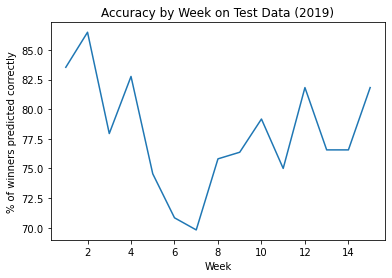

In [38]:
acc = []
for week in range(1, 16):
  t = test.loc[test.week == week]
  t_in = t.drop(columns=['result'])
  t_out = t.result
  t_out[t_out>0] = 1
  t_out[t_out<0] = 0
  tensor_in = torch.tensor(t_in.to_numpy(), dtype=torch.float, device=device)
  output = modelWinner(tensor_in)
  preds = torch.argmax(output, dim=1).detach().cpu().numpy()
  acc.append((np.sum(preds==t_out) / len(t_out))*100.0)
  
plt.plot(range(1, 16), acc)
plt.xlabel('Week')
plt.ylabel('% of winners predicted correctly')
plt.title('Accuracy by Week on Test Data (2019)')

# Compare Best Model to Vegas<a name="compare-vegas"></a>

In [39]:
def predict_betting_wins(pred, spread, result):
  '''
  predict the percent of the time that you beat vegas in betting

  Paramters
  ---------
  prediction : torch.tensor
      vector of predictions of length (N,) where N is number of games
  spread : torch.tensor
      vector of vegas spreads of length (N,) where N is number of games
  result : torch.tensor
      vector of actual game results of length (N,) where N is number of games

  Returns
  -------
  winning_percentage : float
      percent of time that vegas is beat
  '''
  spread_v_pred = torch.sign(pred - spread)
  spread_v_result = torch.sign(result - spread)
  winning_percentage = torch.sum(spread_v_result == spread_v_pred)/result.size()[0]
  return winning_percentage

def calculate_return(winning_percentage):
  return ((winning_percentage * 21/11) - 1) * 100.0

In [40]:
_, _, test = split_data()

test_in = test.drop(columns=['result'])
test_in_tensor = torch.tensor(test_in.to_numpy(), dtype=torch.float, device=device)
pred = modelSpread(test_in_tensor)
pred = torch.reshape(pred, (-1,))

result = torch.tensor(test.result.to_numpy(), dtype=torch.float, device=device)
vegas = torch.tensor(test.spread.to_numpy(), dtype=torch.float, device=device)

beating_vegas = predict_betting_wins(pred, vegas, result)
print('Percentage of Vegas bets this model would\'ve won: %.4f%%' % (beating_vegas))
print('Average return on investement betting with this model: %.2f%%' % (calculate_return(beating_vegas)))

Percentage of Vegas bets this model would've won: 0.7017%
Average return on investement betting with this model: 33.95%


## New Section John's NN Model

# Summary<a name="summary"></a>

Sample data format:

In [41]:
games.loc[(games.home_team == 'Washington') & (games.season == 2015)]

,id,season,week,home_team,away_team,excitement_index,result,spread,homeWinProb,home_games,away_games,firstDowns,fourthDownConversions,fourthDowns,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,interceptions,kickReturnTDs,kickReturnYards,kickReturns,netPassingYards,passAttempts,passCompletions,passesIntercepted,passingTDs,penalties,penaltyYards,possessionTime,puntReturnTDs,puntReturnYards,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownConversions,thirdDowns,totalYards,turnovers,home_for,home_against,away_for,away_against,home_rank,away_rank,win_difference
1752,400757020,2015,2,Washington,Sacramento State,0.450862,49.0,30.0,0.961,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,16.000000,0.000000,0.000000,-1.0,-1.0,0.000000
1849,400757032,2015,3,Washington,Utah State,3.141362,14.0,3.5,0.582,2.0,2.0,-1.000000,1.000000,2.000000,0.000000,0.500000,0.000000,3.000000,-1.000000,0.000,24.500000,1.000000,55.000000,-4.000000,-0.500000,1.000000,0.000000,-4.500000,-61.000000,-136.500000,0.000000,-37.000000,-4.000000,-4.500000,2.500000,-5.000000,-1.000000,-3.000000,50.000000,-1.000000,31.000000,8.000000,13.000000,16.500000,-1.0,-1.0,0.000000
1915,400757040,2015,4,Washington,California,5.311134,-6.0,-2.0,0.453,3.0,3.0,-9.000000,-0.666667,0.333333,0.000000,-0.333333,-0.666667,19.333333,-0.333333,0.000,24.333333,1.000000,-72.000000,-6.666667,-6.333333,-1.333333,-1.666667,-1.000000,-12.000000,-112.333333,0.333333,35.000000,0.333333,-7.666667,-1.000000,-102.666667,0.000000,0.666667,-174.666667,-0.333333,31.000000,11.000000,51.000000,21.666667,-1.0,-1.0,-0.333333
2110,400757054,2015,7,Washington,Oregon,4.521294,-6.0,0.0,0.000,5.0,6.0,-8.466667,-0.900000,-1.600000,0.533333,-0.400000,-0.166667,14.733333,0.000000,0.000,-65.633333,-3.100000,22.000000,2.066667,1.266667,0.400000,-0.633333,-2.566667,-18.566667,20.666667,0.033333,9.933333,0.233333,-19.300000,-1.200000,-206.066667,-0.800000,-1.400000,-184.066667,0.533333,26.800000,15.000000,41.500000,38.666667,-1.0,-1.0,0.100000
2219,400757062,2015,9,Washington,Arizona,2.742335,46.0,0.0,0.000,7.0,8.0,-10.214286,-0.321429,-0.875000,-0.017857,0.178571,-0.125000,17.375000,0.732143,0.000,23.892857,0.857143,-40.892857,-5.464286,-3.321429,0.392857,-1.125000,-0.392857,-2.642857,5.375000,0.017857,7.303571,0.803571,-13.750000,-1.410714,-159.964286,-2.964286,-2.446429,-200.857143,0.714286,24.000000,18.857143,41.750000,32.375000,-1.0,-1.0,-0.196429
2273,400757071,2015,10,Washington,Utah,7.818279,-11.0,0.0,0.000,8.0,8.0,-3.625000,-1.000000,-1.000000,0.375000,-0.250000,-0.125000,1.000000,-0.250000,-0.125,21.875000,0.875000,9.125000,0.250000,-2.625000,-0.250000,-0.125000,0.250000,6.000000,-346.250000,-0.125000,-18.750000,-1.000000,-9.875000,-0.125000,-46.125000,-1.625000,-2.375000,-37.000000,0.125000,27.125000,16.875000,33.750000,21.375000,-1.0,13.0,-0.375000
2414,400757086,2015,13,Washington,Washington State,3.400944,35.0,5.5,0.627,11.0,11.0,-7.090909,-1.545455,-1.545455,0.272727,-0.272727,-0.090909,7.090909,0.000000,0.000,-0.454545,0.000000,-168.454545,-25.909091,-20.636364,0.272727,-1.909091,-0.454545,7.909091,-116.181818,0.181818,17.454545,0.454545,11.000000,1.000000,60.545455,-1.545455,-2.090909,-107.909091,0.272727,28.090909,18.454545,34.454545,27.363636,-1.0,20.0,-0.272727


Results:

| Model | Validation RMSE (points) | Validation Accuracy (%) | Test RMSE (points) | Test Accuracy (%) |
| :---: | :---: | :---: | :---: | :---: |
| Vegas Spreads | - | - | 16.54 | 75.7 |
| Simple Linear | - | - | 20.53 | 72.1 |
| Complex Linear | - | - | 15.47 | 77.7 |
| Complex Linear w/ L1 | 16.66 | - | 18.35 | 77.5 |
| Random Forest | - | 76.67 | - | 78.8 |
| Neural Net for Spread Prediction | 14.74 | - | 12.89 | - |
| Neural Net for Winner Prediction | - | 72.64 | - | - |